In [1]:
import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as fun
import numpy as np
import pandas as pd

In [2]:
from lib.data import load_dataset

x_train, y_train, x_valid, y_valid = load_dataset('dts/dts_plain/train.csv')

In [3]:
from sklearn.preprocessing import StandardScaler
from nn_lucy import dts

sc = StandardScaler()
sc.fit(x_train)

x_train = sc.transform(x_train.values)
x_valid = sc.transform(x_valid.values)
train_dts = dts(x_train,y_train)
valid_dts = dts(x_valid,y_valid)

d:\Users\lucya\anaconda3\envs\ACA\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
d:\Users\lucya\anaconda3\envs\ACA\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [4]:
from torch.utils.data import DataLoader
training_loader = DataLoader(train_dts, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dts, batch_size=32, shuffle=True)

In [7]:
from nn_lucy import nnModel

model = nnModel(inFeatures = x_train.shape[1], random_state=2)

losses, accs = model.fit(
    trainloader=training_loader,
    validloader=valid_loader,
    learningRate=0.01,
    momentum=0.9,
    gamma=0.97,
    numEpochs=31,
    verbose=False
)

[381.97698649019003, 183.54473230615258, 128.38842084538192, 100.57349753053859, 75.505225333618, 66.78565103566507, 55.080837019893806, 44.963897843204904, 40.69224328844575, 36.15233917553269, 27.32957232971239, 23.392042767816747, 22.03613150909132, 17.860511323872743, 16.3154375407953, 11.194658886400248, 13.369380139023406, 10.936656927191166, 8.44544055752931, 4.553483350323376, 4.007494058035007, 3.4657381681724075, 4.32501524226155, 3.5659960119603795, 3.2936396533502297, 3.251723959320433, 3.235099064358401, 3.2253482264435505, 3.2177932559723175, 3.2115964118564353, 3.20632934270719]
[96.15, 96.8, 97.4625, 97.3375, 97.95, 97.95]


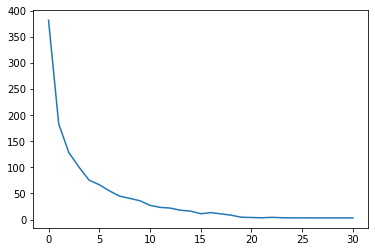

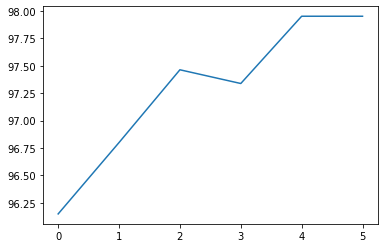

In [8]:
print(losses)
print(accs)

from matplotlib import pyplot as plt
plt.figure()
plt.plot(losses)
plt.figure()
plt.plot(accs)

In [11]:
x_test = load_dataset('dts/dts_plain/test.csv', test_only=True)
# testing_set_ = dataset(x_test, np.zeros(x_test.shape))
# x_test_loader = DataLoader(testing_set_, batch_size=32)

x_test = sc.transform(x_test)

In [12]:
# model = model.to(torch.device('cpu'))

# tst = torch.tensor(x_test, dtype=torch.float32).to(torch.device('cuda'))

ypred = model.predict(torch.tensor(x_test, dtype=torch.float32))


In [14]:
import pandas as pd
result = pd.DataFrame(data={
        "Id": range(len(ypred)),
        "Category": ypred.astype(int)
    }, index=None)

result.to_csv("result.csv", index=None)

In [34]:
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler

training_loader = DataLoader(train_dts, batch_size=32, shuffle=True)
# testing_loader=DataLoader(testing_set, batch_size=8, shuffle=True)

In [7]:
from math import sqrt
class network(nn.Module):
    def __init__(self, n_features):
        super(network, self).__init__()
        self.linear1 = nn.Linear(in_features=n_features, out_features=int(sqrt(n_features)))
        self.linear2 = nn.Linear(in_features=int(sqrt(n_features)), out_features=n_features)
        self.classification = nn.Linear(in_features=n_features, out_features=1)
    def activation(self, f):
        return fun.relu(f)
    def forward(self, x):
        x = self.activation(self.linear1(x))
        x = self.activation(self.linear2(x))
        x = self.classification(x)
        x = fun.sigmoid(x)
        return x

In [35]:
from nn_lucy import nnModel

In [36]:
def train(number_of_epochs, net, training_loader):
    criterion = nn.BCELoss()
    optimizer = opt.SGD(params=net.parameters(), lr=0.5, momentum=0.2, weight_decay=0.9)
    running_loss = 0
    net.train()
    for epoch in range(number_of_epochs):
        for batch_id, data in enumerate(training_loader):
            imgs, labels = data
            y_pred = net(imgs)

            # print(y_pred)
            loss = criterion(y_pred, labels.reshape(-1, 1))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if batch_id % 1000 == 99: # prints every 1000 batchs
                print('[%d, %5d] loss: %.5f' % (epoch + 1, batch_id + 1, running_loss / 1000))
            running_loss = 0.0


In [37]:
from sklearn.metrics import confusion_matrix
def test(testing_loader, net):
    correct = 0
    total = 0
    class_correct = list(0. for i in range(2))
    class_total = list(0. for i in range(2))
    net.eval()
    acc = 0
    with torch.no_grad():
        for batch_id, data in enumerate(testing_loader):
            imgs, labels = data
            predicted = net(imgs)
            
            # _, predicted = torch.max(outputs.data, 1)
            aux = []
            
            for i in range(len(predicted)):
                if predicted[i] > 0.5:
                    aux.append(1)
                else: aux.append(0)
            for p in range(len(aux)):
                if labels[p] == aux[    p]:
                    if labels[p] == 1:
                        class_correct[0] += 1
                    else:
                        class_correct[1] += 1
                if labels[p] == 1:
                    class_total[0] += 1
                else:
                    class_total[1] += 1
        
        return class_correct, class_total
        

In [42]:
model = nnModel(inFeatures = x_train.shape[1], random_state=2)
# train(number_of_epochs=10, net=model, training_loader=training_loader)
losses, accs = model.fit(
    trainloader=training_loader,
    learningRate=0.1,
    momentum=0.9,
    gamma=1,
    numEpochs=11,
    verbose=False
)

In [43]:
losses

[49868.98749542236,
 49896.875,
 49896.875,
 49896.875,
 49896.875,
 49896.875,
 49896.875,
 49896.875,
 49896.875,
 49896.875,
 49896.875]

In [12]:
y_pred = model.predict(torch.tensor(x_test.values, dtype=torch.float32))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_addmm)

In [ ]:
class_correct, class_total = test(testing_loader, model)
print("Acc: " + str((class_correct[0] + class_correct[1])/(class_total[0] + class_total[1])))

Acc: 0.84625


In [ ]:
from lib.data import load_dataset

x_test = load_dataset('dts/test.csv', test_only=True)
testing_set_ = dataset(x_test, np.zeros(x_test.shape))
x_test_loader = DataLoader(testing_set_, batch_size=32)

ypred = model.predict(torch.tensor(x_test.values, dtype=torch.float32))
# print(y_pred)

In [ ]:
import pandas as pd
result = pd.DataFrame(data={
        "Id": range(len(ypred)),
        "Category": ypred.astype(int)
    }, index=None)

result.to_csv("result.csv", index=None)